In [18]:
%matplotlib inline
import warnings
from matplotlib_inline import backend_inline
warnings.filterwarnings("ignore")

import random
import paddle

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = paddle.normal(0, 1, (num_examples, len(w)))
    y = paddle.matmul(X, w) + b
    y += paddle.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = paddle.to_tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: Tensor(shape=[2], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.61992109, 0.26980260]) 
label: Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [4.52754974])


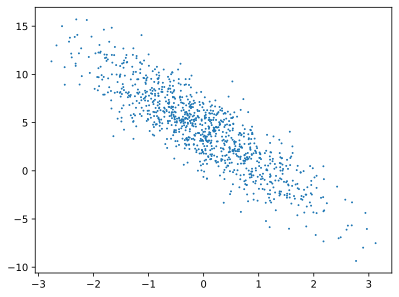

In [22]:
from matplotlib import pyplot as plt

plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

# 添加这一行显示图形
plt.show()

In [27]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = paddle.to_tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [23]:
w = paddle.normal(0, 0.01, shape=(2,1))
b = paddle.zeros(shape=[1])
# w和b为创建的模型参数，stop_gradient默认为True，即梯度不更新，因此需要指定为False已更新梯度
w.stop_gradient = False
b.stop_gradient = False

In [29]:
def linreg(X, w, b):
    """线性回归模型"""
    return paddle.matmul(X, w) + b
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with paddle.no_grad():
        for i, param in enumerate(params):
            param -= lr * params[i].grad / batch_size
            params[i].set_value(param)
            params[i].clear_gradient()

In [31]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # net(X, w, b)是预测的y
        # y是真实的y
        # l得出的是误差
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with paddle.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000047
epoch 2, loss 0.000047
epoch 3, loss 0.000047


In [32]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: Tensor(shape=[2], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [-0.00020480,  0.00046110])
b的估计误差: Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [0.00014067])
